#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [ ]:
!pip install tensorflow

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [ ]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

Ejemplo de salida de una imágen luego de aplicada la transformación Heatmap

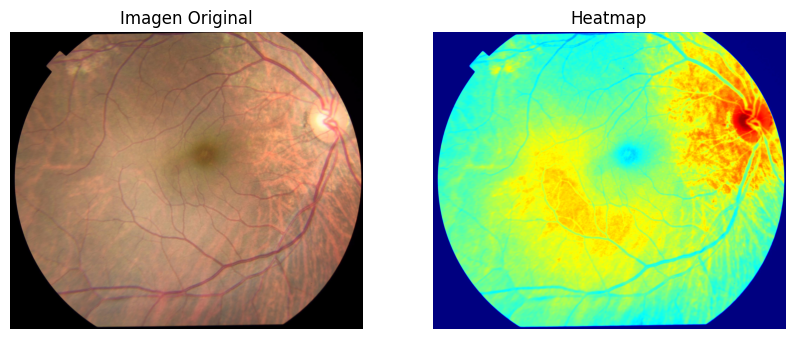

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = '/content/DS_TFE_Final/train/Macular_Scar/Macular Scar1-flip.jpg'
image = cv2.imread(image_path)

# Comprobar y convertir el tipo de la imagen a uint8 si es necesario
if image.dtype != np.uint8:
    image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)

# Convertir la imagen a escala de grises si es necesario
if len(image.shape) == 3 and image.shape[2] == 3:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
elif len(image.shape) == 2:
    gray_image = image
else:
    raise ValueError("Formato de imagen no soportado")

# Aplicar un colormap (heatmap)
heatmap_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

# Mostrar la imagen original y la imagen con heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Heatmap')
plt.imshow(cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

## Importación de librerías necesarias para el notebook

In [ ]:
import pandas
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import glob
import re

Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [ ]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Función para convertir la imágen aplicando el filtro HeatMap.
Esta función se ejecuta al momento de procesar las imagenes en el entrenamiento mediante el ImageDataGenerator

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocessing_image(image):
    # Verificar el tipo de la imagen
    if image.dtype != np.uint8:
        # Normalizar la imagen a rango 0-255
        image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)

    # Convertir la imagen a escala de grises si es necesario
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray_image = image
    else:
        raise ValueError("Formato de imagen no soportado")

    # Aplicar un colormap (heatmap)
    heatmap_image = cv2.applyColorMap(gray_image, cv2.COLORMAP_JET)

    # Redimensionar la imagen al tamaño esperado por el modelo
    heatmap_image_resized = cv2.resize(heatmap_image, (224, 224))

    # Preprocesar la imagen para ResNet50V2
    heatmap_image_preprocessed = preprocess_input(heatmap_image_resized)

    return heatmap_image_preprocessed


## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
val_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)
test_datagen = ImageDataGenerator(rescale = 1./255., preprocessing_function=preprocessing_image)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
input_shape = (224, 224, 3)

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


## Visualizamos algunas de las imagenes del dataset

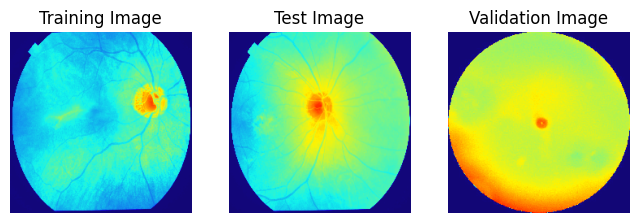

In [ ]:
#Mostramos una imagen de cada conjunto

x_train, y_train = next(train_generator)
x_val, y_val = next(validation_generator)
x_test, y_test = next(test_generator)

# Función para mostrar una imagen
def show_sample(image, title, image2, title2, image3, title3):
    plt.figure(figsize=(8,8))

    plt.subplot(3, 3, 1)
    # Normalizar los datos de la imagen
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

    plt.subplot(3, 3, 2)
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    plt.imshow(image2)
    plt.title(title2)
    plt.axis('off')

    plt.subplot(3, 3, 3)
    image3 = (image3 - image3.min()) / (image3.max() - image3.min())
    plt.imshow(image3)
    plt.title(title3)
    plt.axis('off')

    plt.show()

# Mostrar una imagen de cada conjunto
show_sample(x_train[0], "Training Image", x_test[0], "Test Image", x_val[0], "Validation Image")

## Preparamos la configuración para todos los graficos que vamos a utilizar

In [ ]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.show()


La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [ ]:
from sklearn.metrics import classification_report

def calcular_metricas_por_clase(modelo, y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [ ]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
base_model1 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model1.layers:
    layer.trainable = False


model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(6, activation='softmax'))
model1.summary()

model1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)


94668760/94668760 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 23827846 (90.90 MB)
Trainable params: 26304

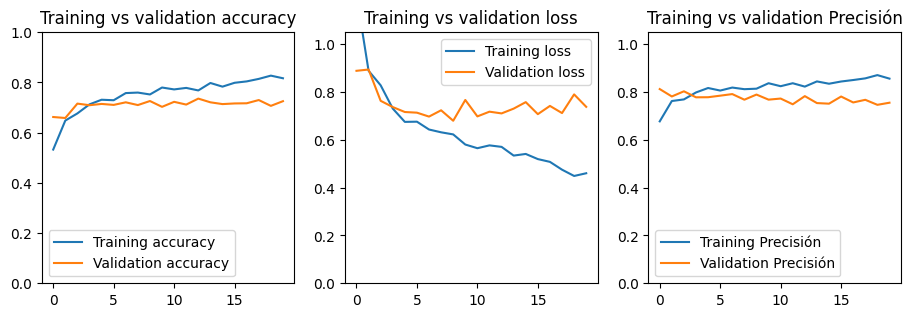

In [ ]:
graph(history1)

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)

39/39 [==============================] - 16s 415ms/step


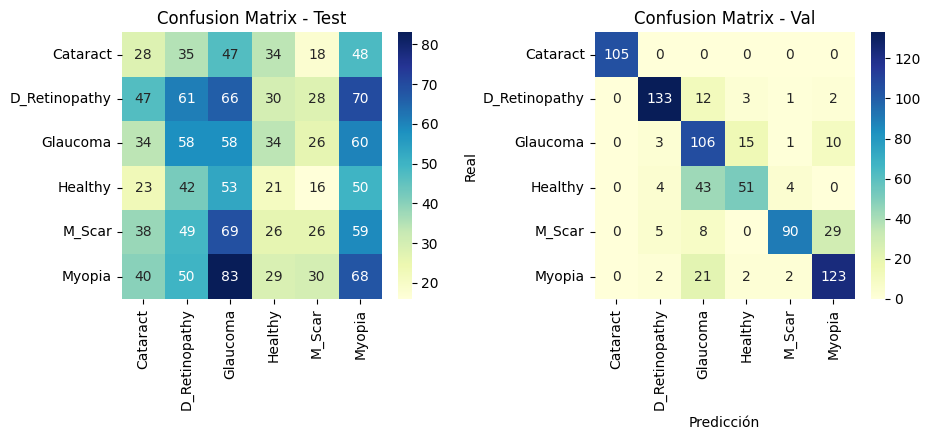

In [ ]:
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model1, y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model1, y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.13      0.13      0.13       210
           1       0.21      0.20      0.20       302
           2       0.15      0.21      0.18       270
           3       0.12      0.10      0.11       205
           4       0.18      0.10      0.13       267
           5       0.19      0.23      0.21       300

    accuracy                           0.17      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.90      0.88      0.89       151
           2       0.56      0.79      0.65       135
           3       0.72      0.50      0.59       102
           4       0.92      0.68      0.78       132
           5       0.75      0.82      0.78       150

    accuracy                           0.78       775
   macro avg       0.81

## Modelo 4

In [ ]:
base_model4 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

94668760/94668760 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 24123014 (92.02 MB)
Trainable params: 55821

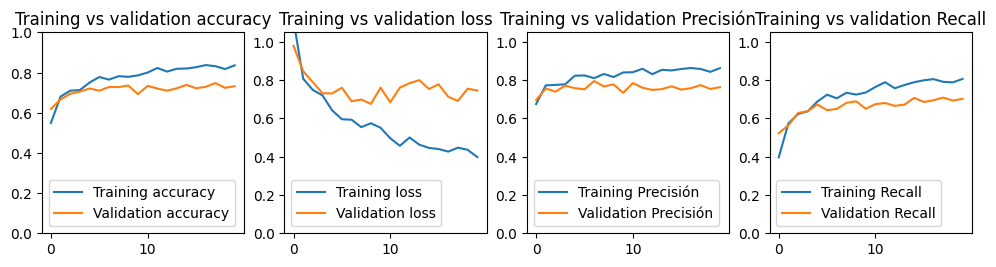

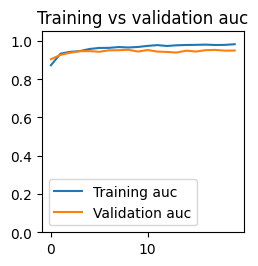

In [ ]:
graph(history4)

In [ ]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 15s 389ms/step


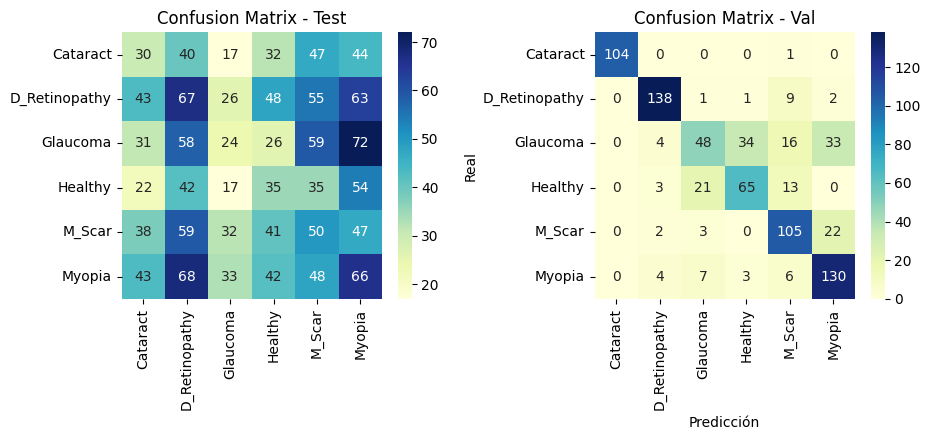

In [ ]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model4, y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model4, y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.20      0.22      0.21       302
           2       0.16      0.09      0.11       270
           3       0.16      0.17      0.16       205
           4       0.17      0.19      0.18       267
           5       0.19      0.22      0.20       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.18      0.17      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.91      0.91      0.91       151
           2       0.60      0.36      0.45       135
           3       0.63      0.64      0.63       102
           4       0.70      0.80      0.74       132
           5       0.70      0.87      0.77       150

    accuracy                           0.76       775
   macro avg       0.76

## Modelo 5

In [ ]:
# Cargar DenseNet121 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model5 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model5.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))

#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

94668760/94668760 [==============================] - 2s 0us/step
Epoch 1/20
100/100 [==============================] - 79s 635ms/step - loss: 1.2149 - accuracy: 0.5090 - precision: 0.6689 - recall: 0.3485 - auc: 0.8478 - val_loss: 1.0305 - val_accuracy: 0.5959 - val_precision: 0.7582 - val_recall: 0.3855 - val_auc: 0.8948
Epoch 2/20
100/100 [==============================] - 62s 625ms/step - loss: 0.9430 - accuracy: 0.6135 - precision: 0.7309 - recall: 0.4814 - auc: 0.9091 - val_loss: 0.8464 - val_accuracy: 0.6789 - val_precision: 0.7750 - val_recall: 0.5541 - val_auc: 0.9269
Epoch 3/20
100/100 [==============================] - 62s 623ms/step - loss: 0.8708 - accuracy: 0.6615 - precision: 0.7612 - recall: 0.5355 - auc: 0.9235 - val_loss: 0.8318 - val_accuracy: 0.6686 - val_precision: 0.7631 - val_recall: 0.5888 - val_auc: 0.9300
Epoch 4/20
100/100 [==============================] - 62s 618ms/step - loss: 0.7671 - accuracy: 0.7078 - precision: 0.7876 - recall: 0.6200 - auc: 0.9406 - va

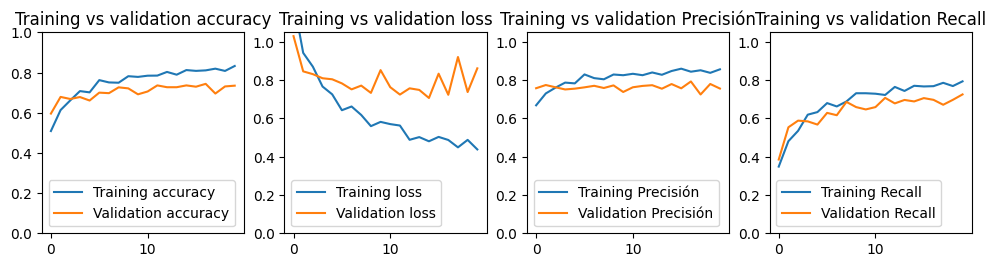

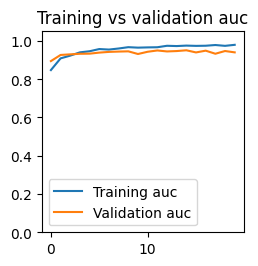

In [ ]:
graph(history5)

39/39 [==============================] - 16s 411ms/step


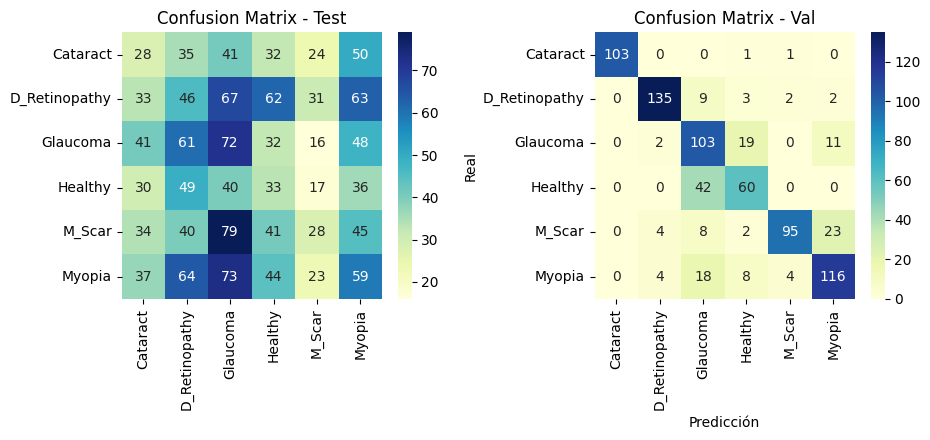

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model5, y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model5, y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.13      0.14       210
           1       0.16      0.15      0.15       302
           2       0.19      0.27      0.22       270
           3       0.14      0.16      0.15       205
           4       0.20      0.10      0.14       267
           5       0.20      0.20      0.20       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       105
           1       0.93      0.89      0.91       151
           2       0.57      0.76      0.65       135
           3       0.65      0.59      0.62       102
           4       0.93      0.72      0.81       132
           5       0.76      0.77      0.77       150

    accuracy                           0.79       775
   macro avg       0.81

## Modelo 15

In [ ]:
base_model15 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model15.layers:
    layer.trainable = False


model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))
model15.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 2056)              4212744   
                                                                 
 dense_8 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                      

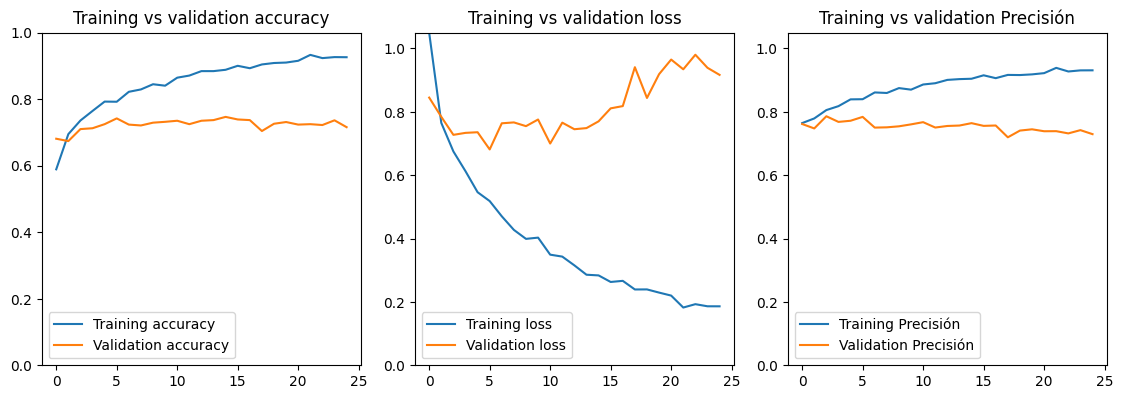

In [ ]:
graph(history15)

39/39 [==============================] - 14s 363ms/step


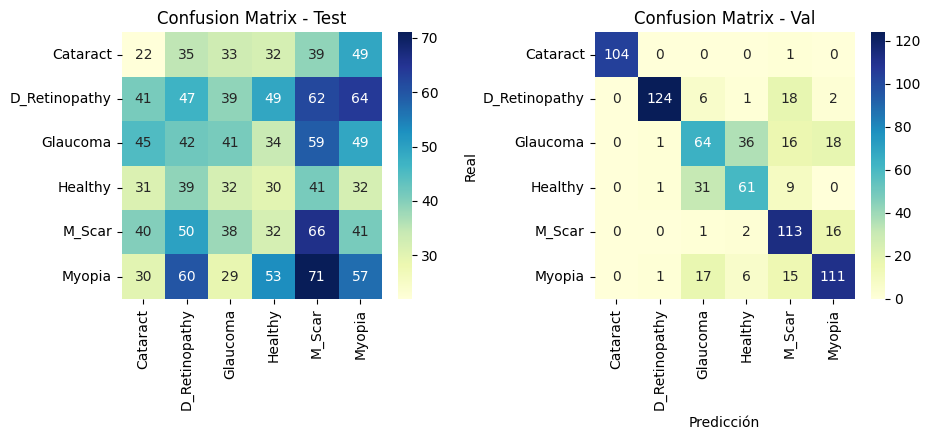

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model15, y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model15, y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.10      0.11       210
           1       0.17      0.16      0.16       302
           2       0.19      0.15      0.17       270
           3       0.13      0.15      0.14       205
           4       0.20      0.25      0.22       267
           5       0.20      0.19      0.19       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.98      0.82      0.89       151
           2       0.54      0.47      0.50       135
           3       0.58      0.60      0.59       102
           4       0.66      0.86      0.74       132
           5       0.76      0.74      0.75       150

    accuracy                           0.74       775
   macro avg       0.75

## Modelo 16

In [ ]:
base_model16 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 2056)              4212744   
                                                                 
 dropout_1 (Dropout)         (None, 2056)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                      

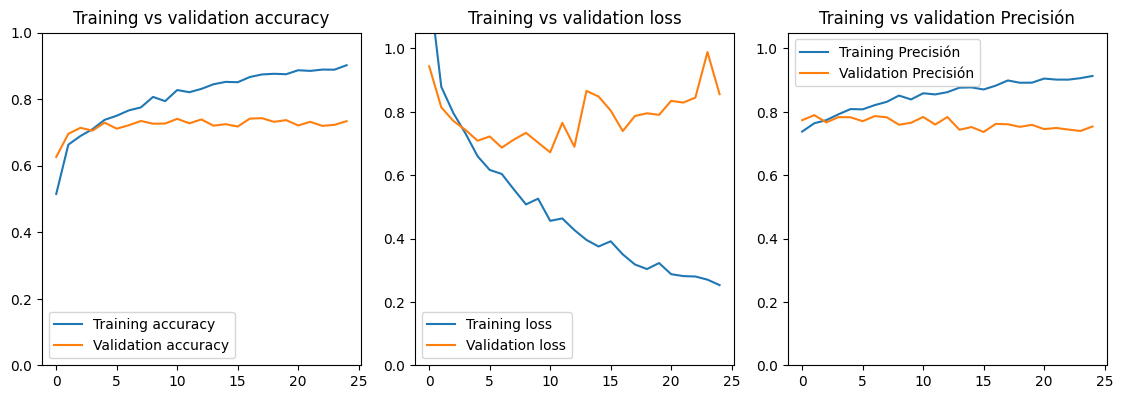

In [ ]:
graph(history16)

39/39 [==============================] - 15s 401ms/step


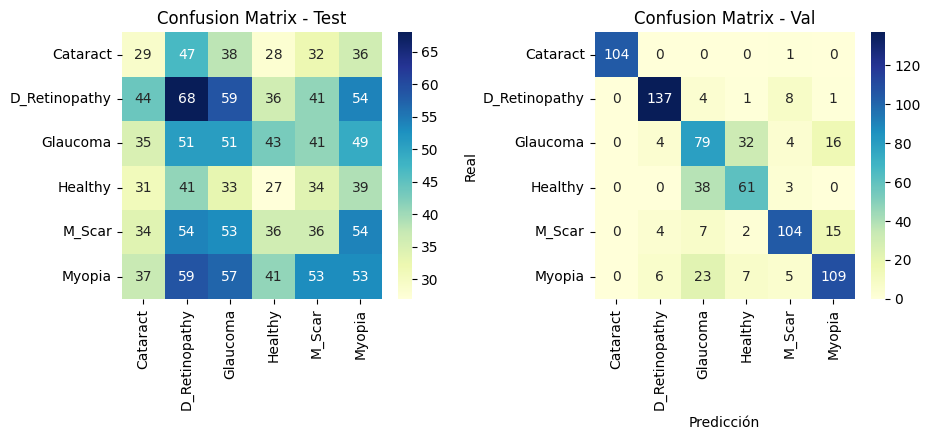

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model16, y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model16, y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.14      0.14      0.14       210
           1       0.21      0.23      0.22       302
           2       0.18      0.19      0.18       270
           3       0.13      0.13      0.13       205
           4       0.15      0.13      0.14       267
           5       0.19      0.18      0.18       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.91      0.91      0.91       151
           2       0.52      0.59      0.55       135
           3       0.59      0.60      0.60       102
           4       0.83      0.79      0.81       132
           5       0.77      0.73      0.75       150

    accuracy                           0.77       775
   macro avg       0.77

## Modelo 6

In [ ]:
base_model6 = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 5112)              10474488  
                                                                 
 dense_4 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_5 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                      

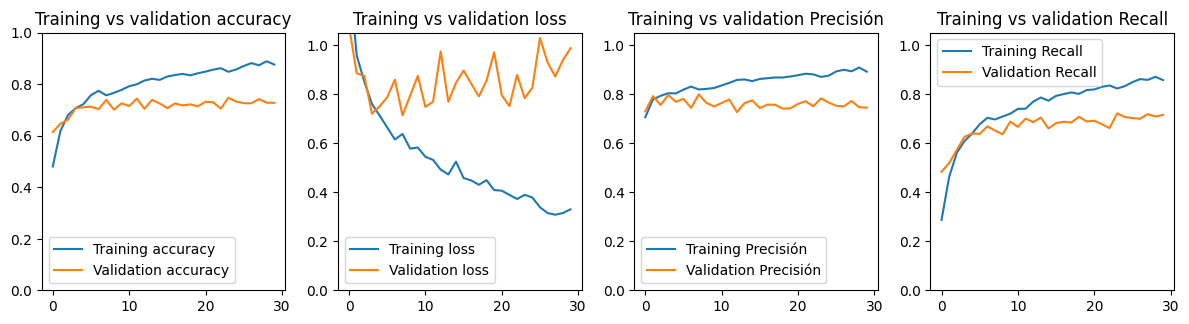

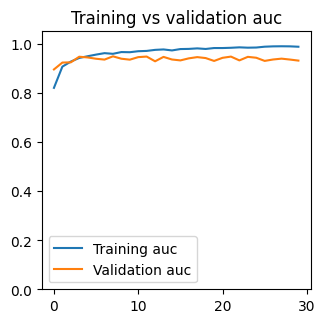

In [ ]:
graph(history6)

In [ ]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 13s 330ms/step


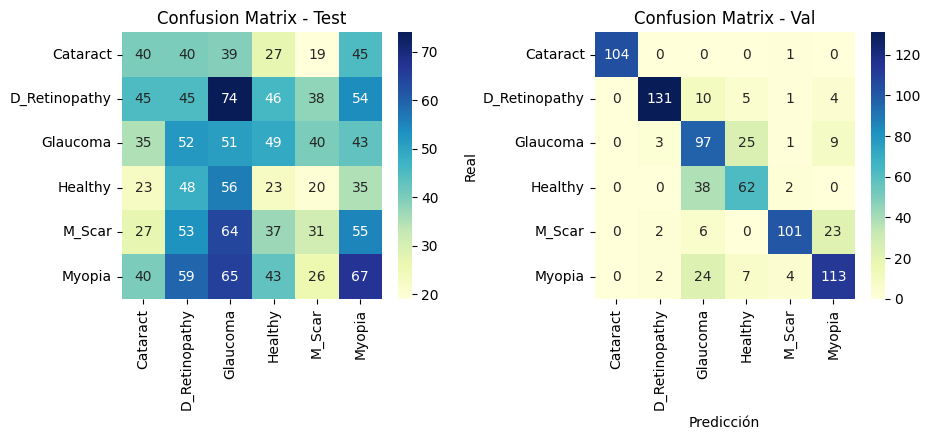

In [ ]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model6, y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model6, y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.19      0.19      0.19       210
           1       0.15      0.15      0.15       302
           2       0.15      0.19      0.16       270
           3       0.10      0.11      0.11       205
           4       0.18      0.12      0.14       267
           5       0.22      0.22      0.22       300

    accuracy                           0.17      1554
   macro avg       0.17      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.95      0.87      0.91       151
           2       0.55      0.72      0.63       135
           3       0.63      0.61      0.62       102
           4       0.92      0.77      0.83       132
           5       0.76      0.75      0.76       150

    accuracy                           0.78       775
   macro avg       0.80

## Modelo 20


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

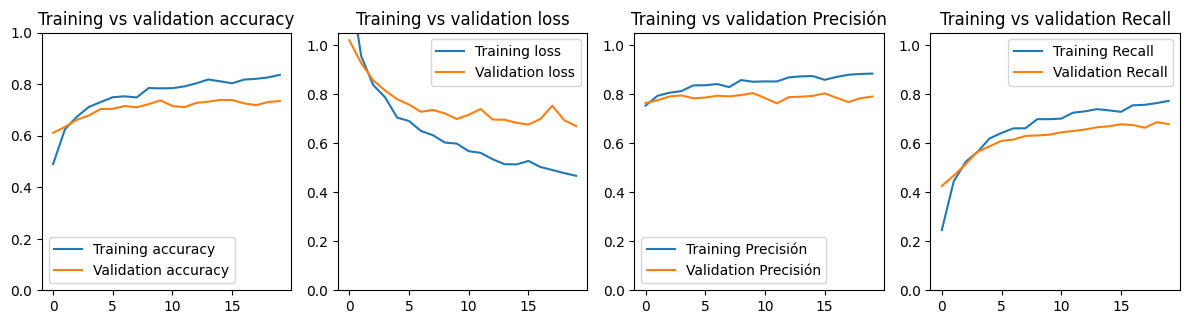

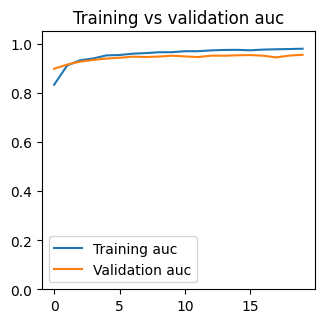

In [ ]:
graph(history_dense)

39/39 [==============================] - 13s 343ms/step


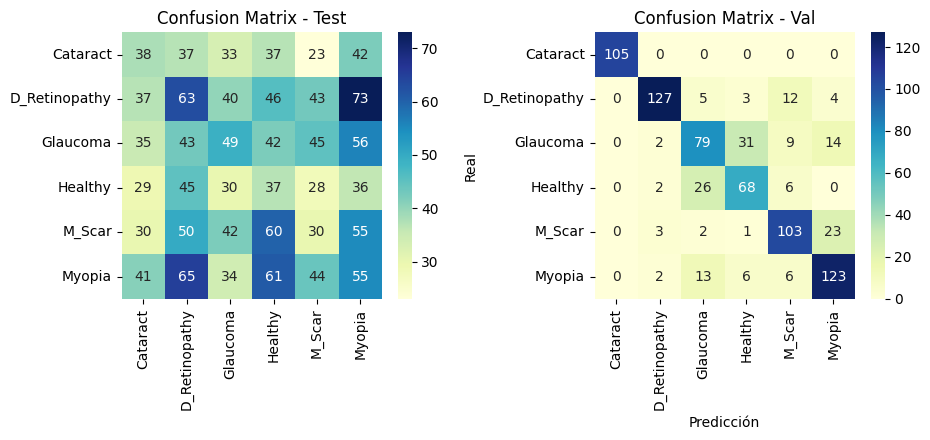

In [ ]:
y_pred_test = model.predict(test_generator)
y_pred_val = model.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model, y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model, y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.18      0.18      0.18       210
           1       0.21      0.21      0.21       302
           2       0.21      0.18      0.20       270
           3       0.13      0.18      0.15       205
           4       0.14      0.11      0.13       267
           5       0.17      0.18      0.18       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.93      0.84      0.89       151
           2       0.63      0.59      0.61       135
           3       0.62      0.67      0.64       102
           4       0.76      0.78      0.77       132
           5       0.75      0.82      0.78       150

    accuracy                           0.78       775
   macro avg       0.78

## Modelo 19

In [ ]:

# Cargar ResNet50V2 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 81s 512ms/step - loss: 1.4874 - accuracy: 0.3723 - precision: 0.7500 - recall: 0.1263 - auc: 0.7447 - val_loss: 1.1332 - val_accuracy: 0.5579 - val_precision: 0.8208 - val_recall: 0.2535 - val_auc: 0.8751
Epoch 2/25
150/150 [==============================] - 75s 501ms/step - loss: 1.1459 - accuracy: 0.5327 - precision: 0.7542 - recall: 0.3273 - auc: 0.8619 - val_loss: 0.9427 - val_accuracy: 0.6287 - val_precision: 0.7673 - val_recall: 0.4562 - val_auc: 0.9107
Epoch 3/25
150/150 [==============================] - 91s 607ms/step - loss: 1.0311 - accuracy: 0.5819 - precision: 0.7375 - recall: 0.4151 - auc: 0.8908 - val_loss: 0.8670 - val_accuracy: 0.6602 - val_precision: 0.8121 - val_recall: 0.4755 - val_auc: 0.9258
Epoch 4/25
150/150 [==============================] - 75s 503ms/step - loss: 0.9567 - accuracy: 0.6153 - precision: 0.7517 - recall: 0.4733 - auc: 0.9063 - val_loss: 0.8333 - val_accuracy: 0.6750 - val_precision: 0.7859 - v

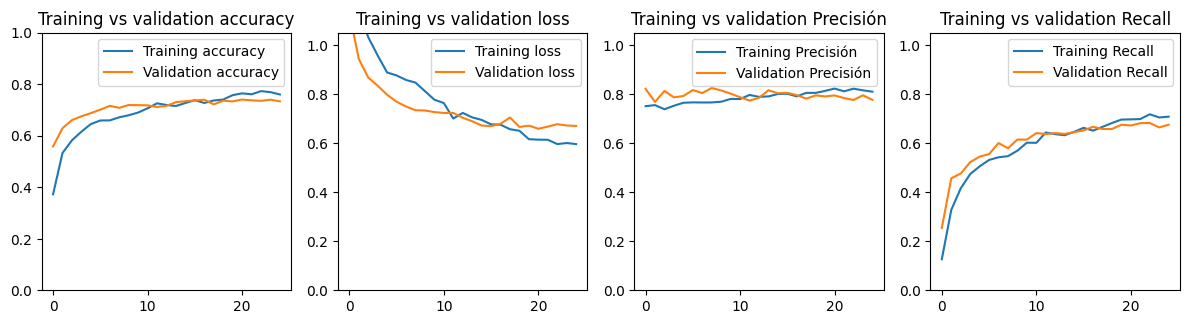

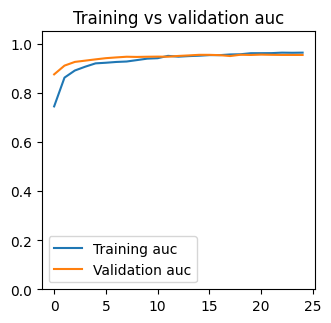

In [ ]:
graph(history19)

39/39 [==============================] - 14s 353ms/step


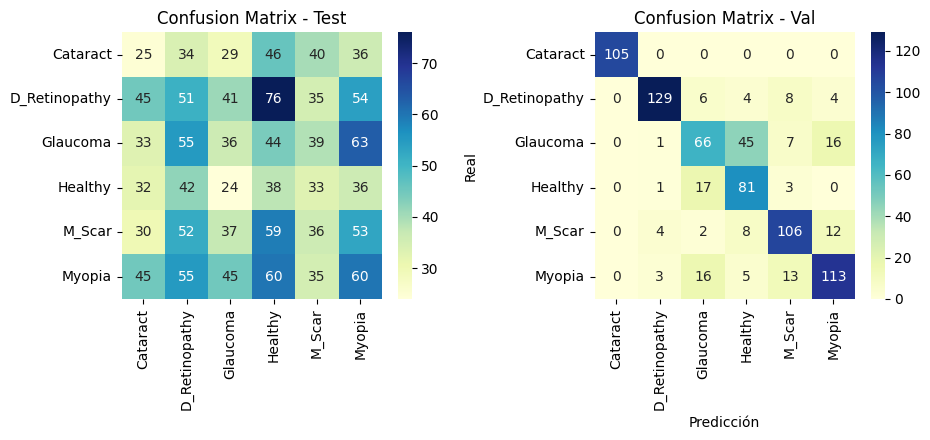

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(model19, y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(model19, y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.18      0.17      0.17       302
           2       0.17      0.13      0.15       270
           3       0.12      0.19      0.14       205
           4       0.17      0.13      0.15       267
           5       0.20      0.20      0.20       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.16      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.93      0.85      0.89       151
           2       0.62      0.49      0.55       135
           3       0.57      0.79      0.66       102
           4       0.77      0.80      0.79       132
           5       0.78      0.75      0.77       150

    accuracy                           0.77       775
   macro avg       0.78

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 107s 392ms/step - loss: 0.4288 - accuracy: 0.8334 - precision: 0.8612 - recall: 0.7953 - auc: 0.9809
Evaluar con Validación:
78/78 [==============================] - 28s 359ms/step - loss: 0.7379 - accuracy: 0.7252 - precision: 0.7551 - recall: 0.6905 - auc: 0.9494
Evaluar con Prueba:
39/39 [==============================] - 14s 365ms/step - loss: 0.5881 - accuracy: 0.7845 - precision: 0.8140 - recall: 0.7510 - auc: 0.9652


In [ ]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 91s 334ms/step - loss: 0.3688 - accuracy: 0.8597 - precision: 0.8900 - recall: 0.8249 - auc: 0.9858
Evaluar con Validación:
78/78 [==============================] - 26s 336ms/step - loss: 0.7461 - accuracy: 0.7323 - precision: 0.7636 - recall: 0.7027 - auc: 0.9500
Evaluar con Prueba:
39/39 [==============================] - 13s 341ms/step - loss: 0.6163 - accuracy: 0.7613 - precision: 0.8100 - recall: 0.7316 - auc: 0.9629


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 90s 332ms/step - loss: 0.4514 - accuracy: 0.8308 - precision: 0.8470 - recall: 0.8176 - auc: 0.9788
Evaluar con Validación:
78/78 [==============================] - 26s 338ms/step - loss: 0.8621 - accuracy: 0.7349 - precision: 0.7565 - recall: 0.7259 - auc: 0.9404
Evaluar con Prueba:
39/39 [==============================] - 13s 337ms/step - loss: 0.6632 - accuracy: 0.7897 - precision: 0.8056 - recall: 0.7755 - auc: 0.9577


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 97s 357ms/step - loss: 0.1714 - accuracy: 0.9359 - precision: 0.9414 - recall: 0.9289 - auc: 0.9967
Evaluar con Validación:
78/78 [==============================] - 28s 354ms/step - loss: 0.9163 - accuracy: 0.7156 - precision: 0.7293 - recall: 0.7040 - auc: 0.9404
Evaluar con Prueba:
39/39 [==============================] - 14s 358ms/step - loss: 0.8015 - accuracy: 0.7445 - precision: 0.7628 - recall: 0.7303 - auc: 0.9487


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 98s 360ms/step - loss: 0.1903 - accuracy: 0.9253 - precision: 0.9346 - recall: 0.9155 - auc: 0.9961
Evaluar con Validación:
78/78 [==============================] - 28s 362ms/step - loss: 0.8555 - accuracy: 0.7336 - precision: 0.7535 - recall: 0.7239 - auc: 0.9449
Evaluar con Prueba:
39/39 [==============================] - 14s 354ms/step - loss: 0.6771 - accuracy: 0.7665 - precision: 0.7776 - recall: 0.7535 - auc: 0.9589


In [ ]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 89s 327ms/step - loss: 0.2985 - accuracy: 0.8906 - precision: 0.9045 - recall: 0.8737 - auc: 0.9896
Evaluar con Validación:
78/78 [==============================] - 25s 321ms/step - loss: 0.9863 - accuracy: 0.7272 - precision: 0.7440 - recall: 0.7143 - auc: 0.9311
Evaluar con Prueba:
39/39 [==============================] - 18s 479ms/step - loss: 0.7851 - accuracy: 0.7845 - precision: 0.7992 - recall: 0.7755 - auc: 0.9508


In [ ]:
evaluar_modelo(model19) # Modelo 19

Evaluar con Entrenamiento:
272/272 [==============================] - 90s 331ms/step - loss: 0.5040 - accuracy: 0.8027 - precision: 0.8536 - recall: 0.7483 - auc: 0.9749
Evaluar con Validación:
78/78 [==============================] - 26s 332ms/step - loss: 0.6693 - accuracy: 0.7329 - precision: 0.7757 - recall: 0.6744 - auc: 0.9541
Evaluar con Prueba:
39/39 [==============================] - 13s 340ms/step - loss: 0.5516 - accuracy: 0.7742 - precision: 0.8319 - recall: 0.7277 - auc: 0.9694


In [ ]:
evaluar_modelo(model) # Modelo 20

Evaluar con Entrenamiento:
272/272 [==============================] - 88s 323ms/step - loss: 0.4182 - accuracy: 0.8553 - precision: 0.9002 - recall: 0.7922 - auc: 0.9851
Evaluar con Validación:
78/78 [==============================] - 27s 342ms/step - loss: 0.6687 - accuracy: 0.7342 - precision: 0.7892 - recall: 0.6770 - auc: 0.9548
Evaluar con Prueba:
39/39 [==============================] - 15s 377ms/step - loss: 0.5585 - accuracy: 0.7806 - precision: 0.8439 - recall: 0.7187 - auc: 0.9683
